## Use Bayesian Linear Regression with Hyperbola equation - Correcting typos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from patsy import bs, dmatrix

import arviz as az

import pymc3 as pm

In [3]:
from agrivoltaics_supply_side_management.agriculture.photosynthetic_rate\
    import PhotosyntheticRate

In [4]:
soybean_net_photosynthetic_rate = pd.read_csv("../../../data/soybean_net_photosynthetic_rate.csv", 
                    index_col="Photosynthetically Active Radiation [micromol / m^2 / s]")

In [5]:
soybean_net_photosynthetic_rate.rename(columns ={'Monocropping - CO2 uptake [micromol / m^2 / s]': 'Monocropping', 
                                         'Intercropping - CO2 uptake [micromol / m^2 / s]': 'Intercropping'},
                               inplace=True)

In [6]:
soybean_net_photosynthetic_rate.index.names = ['PAR']

In [7]:
soybean_net_photosynthetic_rate

,Monocropping,Intercropping
PAR,,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [8]:
ppfd = soybean_net_photosynthetic_rate.index.values

In [9]:
net_photosynthetic_rate_monocropping = soybean_net_photosynthetic_rate.Monocropping.values

In [10]:
net_photosynthetic_rate_intercropping = soybean_net_photosynthetic_rate.Intercropping.values

In [11]:
p_max_monocropping = max(net_photosynthetic_rate_monocropping)

In [12]:
p_max_intercropping = max(net_photosynthetic_rate_intercropping)

In [13]:
p_max_monocropping

25.0

In [14]:
p_max_intercropping

17.0

In [15]:
monocropping_net_photosynthetic_rate_function = \
    PhotosyntheticRate.get_net_photosynthetic_rate_function(
        p_max_monocropping, avoid_nan = False)

In [16]:
intercropping_net_photosynthetic_rate_function = \
    PhotosyntheticRate.get_net_photosynthetic_rate_function(
        p_max_intercropping, avoid_nan = False)

In [17]:
monocropping_net_photosynthetic_rate_function

<function agrivoltaics_supply_side_management.agriculture.photosynthetic_rate.PhotosyntheticRate.get_net_photosynthetic_rate_function.<locals>.net_photosynthetic_rate_function(l, phi, alpha, theta)>

In [18]:
intercropping_net_photosynthetic_rate_function

<function agrivoltaics_supply_side_management.agriculture.photosynthetic_rate.PhotosyntheticRate.get_net_photosynthetic_rate_function.<locals>.net_photosynthetic_rate_function(l, phi, alpha, theta)>

#### Get parameters by curve fitting. We use these values as mean value later in Bayesian Analysis

In [19]:
monocropping_phi, monocropping_alpha, monocropping_theta \
    = PhotosyntheticRate.net_photosynthetic_rate_parameters(ppfd,
        net_photosynthetic_rate_monocropping)

In [20]:
intercropping_phi, intercropping_alpha, intercropping_theta \
    = PhotosyntheticRate.net_photosynthetic_rate_parameters(ppfd,
        net_photosynthetic_rate_intercropping)

In [21]:
monocropping_phi, monocropping_alpha, monocropping_theta

(0.03442841710379512, 0.09510809834054065, 1.327579142408395)

In [22]:
intercropping_phi, intercropping_alpha, intercropping_theta

(0.05498625745316387, 0.12013631354448669, 0.7442598071555129)

#### Use standard deviation value of net photosyntheric rate later in Bayesian Analysis

In [23]:
std_net_photosynthetic_rate_monocropping = soybean_net_photosynthetic_rate.Monocropping.std()

In [24]:
std_net_photosynthetic_rate_monocropping

10.994003186310529

In [25]:
std_net_photosynthetic_rate_intercropping = soybean_net_photosynthetic_rate.Intercropping.std()

In [26]:
std_net_photosynthetic_rate_intercropping

7.192209590096689

### Try Bayesian - monocropping

In [27]:
with pm.Model() as model_monocropping:
    m_std = pm.HalfStudentT('m_sigma', std_net_photosynthetic_rate_monocropping, 100)
    m_phi = pm.Normal('m_phi', monocropping_phi, 1.0)
    m_alpha = pm.Normal('m_alpha', monocropping_alpha, 1.0)
    m_theta = pm.Normal('m_theta', monocropping_theta, 10.0)
    m_mu = pm.Deterministic('m_mu', monocropping_net_photosynthetic_rate_function(ppfd, m_phi, m_alpha, m_theta))

    m_net_photosynthetic_rate = pm.Normal('m_net_photosynthetic_rate', mu=m_mu, sigma=m_std, 
                                          observed=net_photosynthetic_rate_monocropping)
    
    m_idata = pm.sample(3000, tune=2000, return_inferencedata=True)

/Users/tadatoshi/Documents/development/projects/tadatoshi_solar_research_society/agrivoltaics_supply_side_management/agrivoltaics_supply_side_management/agriculture/photosynthetic_rate.py:134: RuntimeWarning: invalid value encountered in sqrt
  - np.sqrt(inside_sqrt)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'m_sigma_log__': array(4.60517019), 'm_phi': array(0.03442842), 'm_alpha': array(0.0951081), 'm_theta': array(1.32757914)}

Initial evaluation results:
m_sigma_log__               -0.77
m_phi                       -0.92
m_alpha                     -0.92
m_theta                     -3.22
m_net_photosynthetic_rate     NaN
Name: Log-probability of test_point, dtype: float64

#### Try Bayesian - intercropping - correct net_photosynthetic_rate_function

In [28]:
with pm.Model() as model_intercropping:
    i_std = pm.HalfStudentT('i_sigma', std_net_photosynthetic_rate_intercropping, 100)
    i_phi = pm.Normal('i_phi', intercropping_phi, 1.0)
    i_alpha = pm.Normal('i_alpha', intercropping_alpha, 1.0)
    i_theta = pm.Normal('i_theta', intercropping_theta, 10.0)
    i_mu = pm.Deterministic('i_mu', intercropping_net_photosynthetic_rate_function(ppfd, i_phi, i_alpha, i_theta))

    i_net_photosynthetic_rate = pm.Normal('i_net_photosynthetic_rate', mu=i_mu, sigma=i_std, 
                                          observed=net_photosynthetic_rate_intercropping)
    
    i_idata = pm.sample(3000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [i_theta, i_alpha, i_phi, i_sigma]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 24 seconds.
There were 1888 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4008081845861813, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2716 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.008202947801335146, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


##### For some reason, intercropping case succeeds. I take it. 

In [29]:
i_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

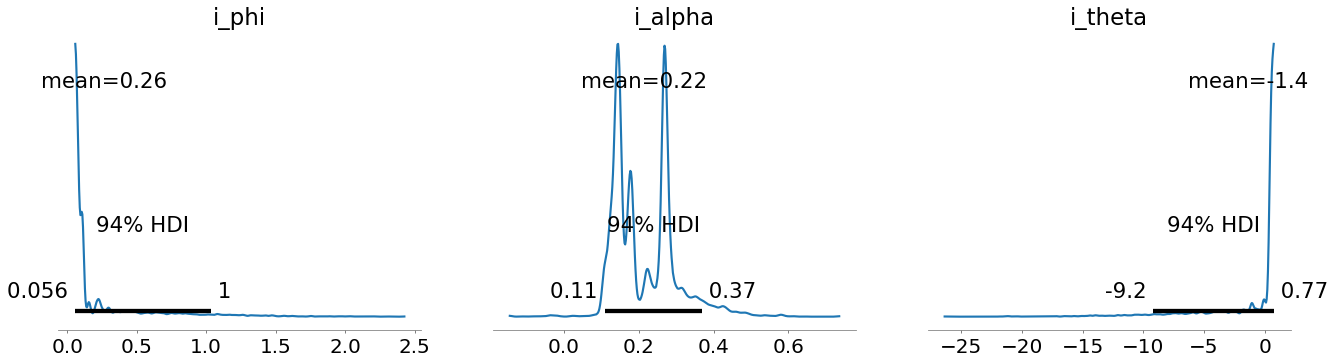

In [30]:
axes = az.plot_posterior(i_idata, var_names = ["i_phi", "i_alpha", "i_theta"], textsize=20);

In [31]:
axes

array([<AxesSubplot:title={'center':'i_phi'}>,
       <AxesSubplot:title={'center':'i_alpha'}>,
       <AxesSubplot:title={'center':'i_theta'}>], dtype=object)

In [32]:
axes[0].get_figure().savefig("../../../plots/net_photosynthetic_rate/posterior_parameters_2.png")

In [59]:
i_idata['posterior']['i_phi'].to_numpy().mean()

0.26361657441094843

In [60]:
i_idata['posterior']['i_alpha'].to_numpy().mean()

0.21573277273021874

In [61]:
i_idata['posterior']['i_theta'].to_numpy().mean()

-1.3571134018787545

### Get light saturation point and net photosynthetic rate at light saturation point

In [33]:
monocropping_light_saturation_point = PhotosyntheticRate.find_light_saturation_point(
                monocropping_phi, monocropping_alpha, monocropping_theta, p_max_monocropping, ppfd)

In [34]:
monocropping_light_saturation_point

400.0

In [45]:
monocropping_net_photosynthetic_rate_light_saturation_point = \
    monocropping_net_photosynthetic_rate_function(monocropping_light_saturation_point, monocropping_phi, monocropping_alpha, monocropping_theta)

In [46]:
monocropping_net_photosynthetic_rate_light_saturation_point

nan

In [43]:
monocropping_net_photosynthetic_rate_at_light_saturation_point = \
    soybean_net_photosynthetic_rate['Monocropping'].loc[monocropping_light_saturation_point]

In [44]:
monocropping_net_photosynthetic_rate_at_light_saturation_point

12.5

In [39]:
intercropping_light_saturation_point = PhotosyntheticRate.find_light_saturation_point(
                intercropping_phi, intercropping_alpha, intercropping_theta, p_max_intercropping, ppfd)

In [40]:
intercropping_light_saturation_point

400.0

In [41]:
intercropping_net_photosynthetic_rate_light_saturation_point = \
    intercropping_net_photosynthetic_rate_function(intercropping_light_saturation_point, intercropping_phi, intercropping_alpha, intercropping_theta)

In [42]:
intercropping_net_photosynthetic_rate_light_saturation_point

11.48017153046819

In [47]:
intercropping_net_photosynthetic_rate_at_light_saturation_point = \
    soybean_net_photosynthetic_rate['Intercropping'].loc[intercropping_light_saturation_point]

In [48]:
intercropping_net_photosynthetic_rate_at_light_saturation_point

11.0

In [49]:
posterior_intercropping_light_saturation_point = PhotosyntheticRate.find_light_saturation_point(
                0.26, 0.22, -1.4, p_max_intercropping, ppfd)

In [50]:
posterior_intercropping_light_saturation_point

400.0

In [51]:
posterior_intercropping_net_photosynthetic_rate_light_saturation_point = \
    intercropping_net_photosynthetic_rate_function(posterior_intercropping_light_saturation_point, 0.26, 0.22, -1.4)

In [52]:
posterior_intercropping_net_photosynthetic_rate_light_saturation_point

11.08497969924465

In [54]:
posterior_intercropping_net_photosynthetic_rate_at_light_saturation_point = \
    soybean_net_photosynthetic_rate['Intercropping'].loc[posterior_intercropping_light_saturation_point]

In [55]:
posterior_intercropping_net_photosynthetic_rate_at_light_saturation_point

11.0